In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Strategy Backtester

## Data

From poloniex:

https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1521746902&end=9999999999&period=14400

In [2]:
import calendar
import requests
import pandas as pd 
from datetime import datetime, timedelta

In [3]:
def unix_epoch_to_timestamp(epoch):
    return datetime.fromtimestamp(epoch).strftime('%Y-%m-%d %H:%M:%S')

In [4]:
def timestamp_to_unix_epoch(ts):
    return calendar.timegm(ts.timetuple())

In [5]:
class PoloniexDataFrame():
    def __init__(self, pair, timeframe, start, end):
        start = timestamp_to_unix_epoch(start)
        end = timestamp_to_unix_epoch(end)
        url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'.format(pair, start, end, timeframe) 
        print(url)
        json = requests.get(url)
        data = json.json()
        date, o, h, l, c = zip(*[(unix_epoch_to_timestamp(x['date']), x['close'], x['high'], x['low'], x['close']) for x in data])
        d = {'date': date, 'open': o, 'high': h, 'low': l, 'close': c}
        self.data = pd.DataFrame(data=d)

In [6]:
import dateutil.parser

In [7]:
dateutil.parser.parse('2018-04-04 17:30:00')

datetime.datetime(2018, 4, 4, 17, 30)

In [8]:
start = datetime.utcnow() - timedelta(days=7*8)
end = datetime.utcnow()
#start = dateutil.parser.parse('2018-04-04 17:30:00')
#end = dateutil.parser.parse('2018-04-12 00:30:00')
                                    # Min * 60 Sec
#plnx = PoloniexDataFrame('USDT_BTC', 5*60, start, end) #  0.45% 
#plnx = PoloniexDataFrame('USDT_BTC', 15*60, start, end) #  -13.02%
plnx = PoloniexDataFrame('USDT_BTC', 30*60, start, end) # 23.65%
#plnx = PoloniexDataFrame('USDT_BTC', 120*60, start, end) # 3.84%
#lnx = PoloniexDataFrame('USDT_BTC', 240*60, start, end) # 10.948%

https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1520088268&end=1524926668&period=1800


'2018-04-04 17:30:00'
'2018-04-12 00:30:00'

## Indicators

Indicators to add:

 * EMA
 * MACD
 * BBands
 * RSI

### Daily returns

In [9]:
def daily_returns(df): df['daily_returns'] = df['close'] - df['close'].shift(1)

### Stdev

In [10]:
def std(df, n): df['std{}'.format(n)] = df['close'].rolling(window=n).std()
std_list = [7]

### Simple Moving Average (SMA)

In [11]:
def sma(df, n): df['sma{}'.format(n)] = df['close'].rolling(window=n).mean()
sma_list = range(1, 30)

### Adding all the data & indicators

In [12]:
daily_returns(plnx.data)
for n in std_list: std(plnx.data, n)
for n in sma_list: sma(plnx.data, n)

In [13]:
class Indicators():
    std_list = [7]
    sma_list = range(5, 30)
    
    def daily_returns(self, df): df['daily_returns'] = df['close'] - df['close'].shift(1)
    def std(self, df, n): df['std{}'.format(n)] = df['close'].rolling(window=n).std()
    def sma(self, df, n): df['sma{}'.format(n)] = df['close'].rolling(window=n).mean()
        
    def apply(self, df):
        self.daily_returns(df)
        for n in self.std_list: self.std(df, n) 
        for n in self.sma_list: self.sma(df, n)

## Plot

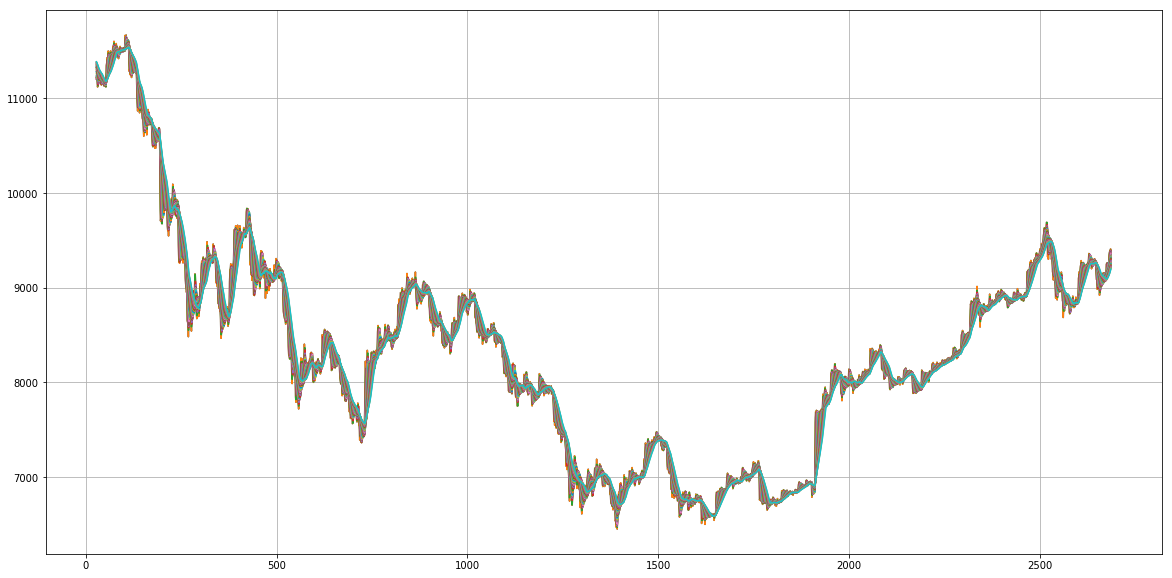

In [14]:
head=max(sma_list)-1
plt.figure(figsize=(20,10))
plot(plnx.data[head:]['close'])
for i in sma_list: plot(plnx.data[head:]['sma{}'.format(i)])
plt.grid()

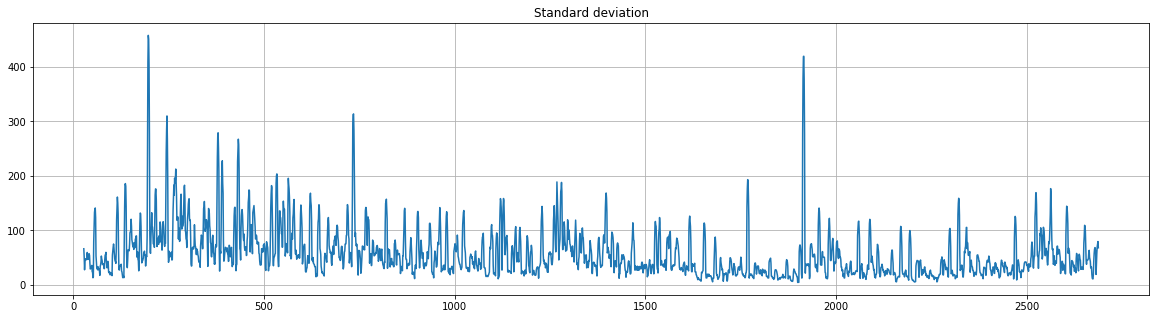

In [15]:
plt.figure(figsize=(20,5))
plot(plnx.data[head:]['std7'])
plt.title('Standard deviation')
plt.grid()

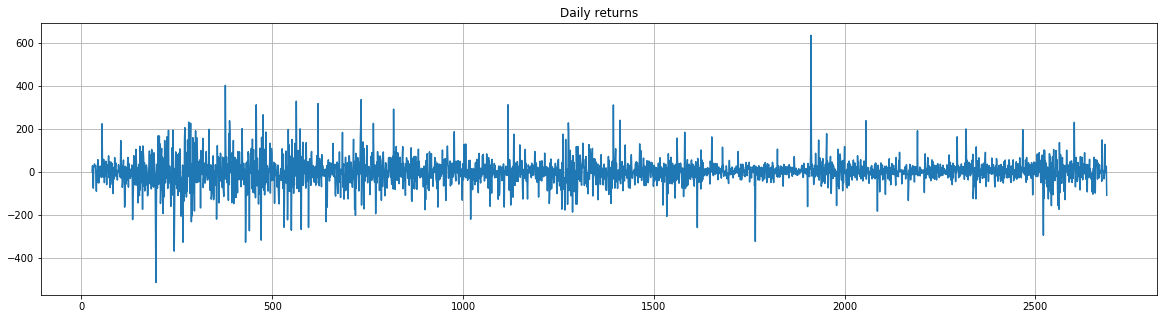

In [16]:
plt.figure(figsize=(20,5))
plot(plnx.data[head:]['daily_returns'])
plt.title('Daily returns')
plt.grid()

## Signals

### Moving average crossover

In [17]:
def signals_ma_crossover(df, skip_head, sma_list):
    sma1 = 'sma{}'.format(sma_list[0])
    sma2 = 'sma{}'.format(sma_list[1])
    df['signal_sma_crossover'] = 0
    for i in range(skip_head, len(df)):
        previous = df.iloc[i-1]
        current = df.iloc[i]
        sma_prev = previous[sma1] - previous[sma2]
        sma_current = current[sma1] - current[sma2]
        if sma_prev > 0 and sma_current < 0: df.loc[i,'signal_sma_crossover'] = -1
        if sma_prev < 0 and sma_current > 0: df.loc[i,'signal_sma_crossover'] = 1

In [18]:
signals = signals_ma_crossover(plnx.data, 23, [7, 23])

## Trading simulation

In [19]:
class RiskManagement():
    def __init__(self, use_stop_loss, stop_loss_percentage):
        self.use_stop_loss = use_stop_loss
        self.stop_loss_percentage = stop_loss_percentage

In [20]:
from matplotlib import gridspec

In [27]:
class TradeSim():
    def __init__(self, df, risk):
        self.df = df
        self.risk = risk
        
    def run(self):
        state = 'neutral'
        entry = None
        entry_timestamp = None
        tlist = []
        for index in range(len(self.df)):
            current = self.df.iloc[index]
            sma_crossover = self.df.loc[index]
            if state != 'neutral':
                pl_low = ((current['low'] / entry if state == 'long' else entry / current['low']) - 1) * 100
                if self.risk.use_stop_loss and pl_low < -self.risk.stop_loss_percentage:
                    tlist.append([entry, current['close'], state, entry_timestamp, current['date'], 'stopped_out'])
                    state = 'neutral'
            if current['signal_sma_crossover'] == 1:
                if state == 'short':
                    tlist.append([entry, current['close'], 'short', entry_timestamp, current['date'], 'closed'])
                    state = 'neutral'
                entry = current['close']
                entry_timestamp = current['date']
                state = 'long'
            if current['signal_sma_crossover'] == -1:
                if state == 'long':
                    tlist.append([entry, current['close'], 'long', entry_timestamp, current['date'], 'closed'])
                    state = 'neutral'
                entry = current['close']
                entry_timestamp = current['date']
                state = 'short'
        self.trades = pd.DataFrame(tlist, columns=['entry', 'exit', 'direction', 'entry_timestamp', 'exit_timestamp', 'close_type'])
        self.trades['gains'] = self.trades.apply(self.gains, axis=1)
        self.trades['gains'] = self.trades.apply(self.stopped_out, axis=1)
        self.trades['gains_cumsum'] = self.trades['gains'].cumsum()
        self.add_gains_to_dataframe()
        
    def gains(self, row):
        if row['direction'] == 'long':  return (row['exit'] / row['entry'] - 1) * 100
        if row['direction'] == 'short': return (row['entry'] / row['exit'] - 1) * 100
        
    def add_gains_to_dataframe(self):
        self.df['gains'] = 0
        for index in range(len(self.trades)):
            t = self.trades.iloc[index]
            self.df.loc[self.df['date'] == t['exit_timestamp'], 'gains'] = t['gains']
        self.df['gains_cumsum'] = self.df['gains'].cumsum()
            
    def stopped_out(self, row):
        return -self.risk.stop_loss_percentage if row['close_type'] == 'stopped_out' else row['gains']
    
    def plot_chart(self):
        plt.figure(figsize=(20,5))
        plot(self.trades['close'])
    
    def plot_gains(self):
        plt.figure(figsize=(20,5))
        plt.title('Gains (cumulative)')
        plot(self.trades['gains_cumsum'])
        plt.grid()
        
    def result_statistics(self):
        winners = len(self.trades.loc[self.trades['gains'] > 0])
        losers = len(self.trades.loc[self.trades['gains'] < 0])
        stopped_out = len(self.trades.loc[self.trades['close_type'] == 'stopped_out'])
        print('Period start: {}'.format(self.df.iloc[0]['date']))
        print('Period end: {}'.format(self.df.iloc[len(self.df)-1]['date']))
        print('Total trades: {}'.format(winners+losers))
        print('Winners: {}'.format(winners))
        print('Losers: {}'.format(losers))
        print('Win Ratio: {:.3f}%'.format(winners / (winners+losers) * 100))
        print('Stopped out: {}'.format(stopped_out))
        print('P/L: {:.2f}%'.format(self.df.iloc[len(self.df)-1]['gains_cumsum']))
        
    def plot_gains_timescale(self):
        gs = gridspec.GridSpec(3, 1, height_ratios=[3,1,1])
        f = plt.figure(figsize=(20,15)) #plt.subplots(gs, sharex=True, figsize=(20,10))
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        ax3 = plt.subplot(gs[2])
        ax1.plot(trade_sim.df['close'], c='black', lw=1.)
        ax1.plot(trade_sim.df['sma8'], c='lightgreen', lw=2.)
        ax1.plot(trade_sim.df['sma23'], c='red', lw=2.)
        ax1.grid()
        ax2.axhline(y=0, c='black', ls='dashed')
        ax2.plot(trade_sim.df['signal_sma_crossover'], c='blue', lw=1.)
        ax2.grid()
        ax3.axhline(y=0, c='black', ls='dashed')
        ax3.plot(trade_sim.df['gains_cumsum'], c='blue', lw=2.)
        ax3.grid()
        f.subplots_adjust(hspace=0)

Period start: 2018-03-03 16:00:00
Period end: 2018-04-28 16:30:00
Total trades: 133
Winners: 44
Losers: 89
Win Ratio: 33.083%
Stopped out: 57
P/L: 39.18%


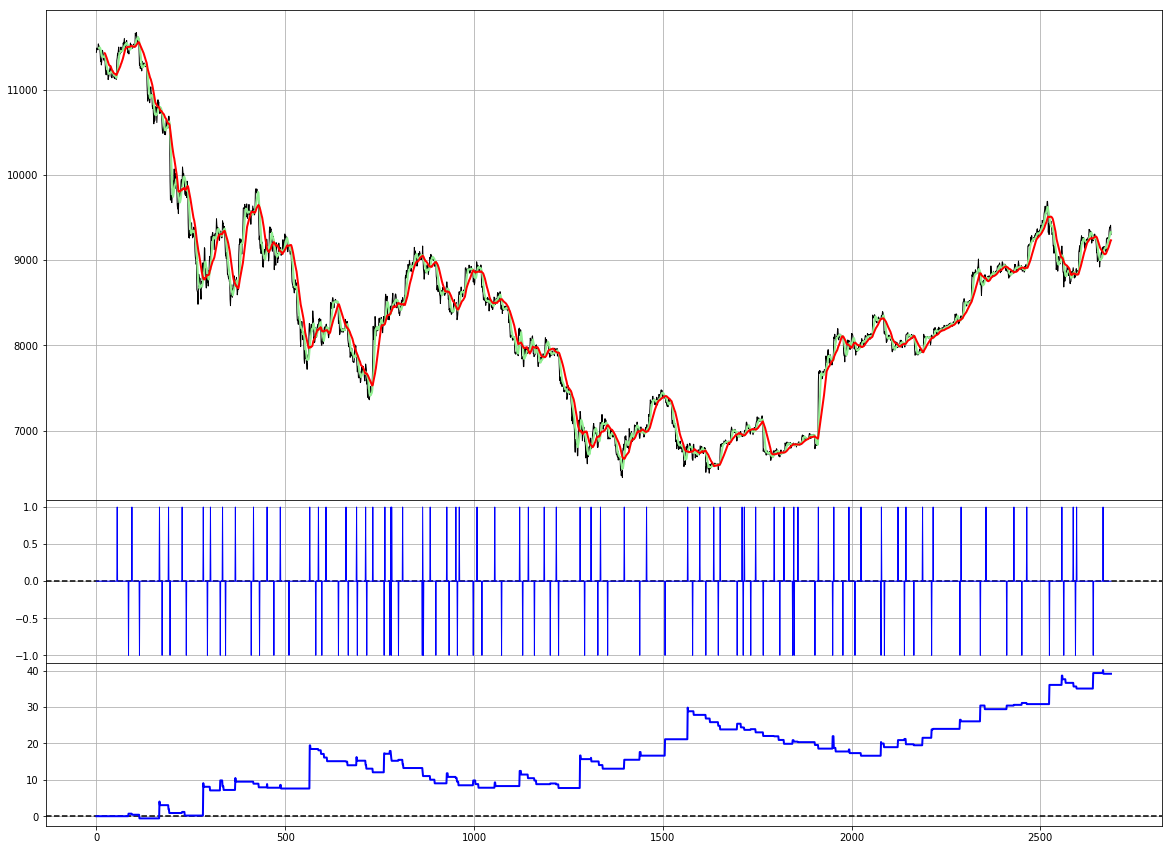

In [28]:
risk_mgmnt = RiskManagement(True, 1)
trade_sim = TradeSim(plnx.data, risk_mgmnt)
trade_sim.run()
trade_sim.result_statistics()
trade_sim.plot_gains_timescale()

In [23]:
trade_sim.trades

,entry,exit,direction,entry_timestamp,exit_timestamp,close_type,gains,gains_cumsum
0,11373.572156,11453.000000,long,2018-03-04 19:30:00,2018-03-05 10:30:00,closed,0.698354,0.698354
1,11453.000000,11487.407700,short,2018-03-05 10:30:00,2018-03-05 15:00:00,closed,-0.299525,0.398829
2,11487.407700,11284.999998,long,2018-03-05 15:00:00,2018-03-06 01:00:00,stopped_out,-1.000000,-0.601171
3,11284.999998,10784.599422,short,2018-03-06 01:00:00,2018-03-07 03:30:00,closed,4.639955,4.038784
4,10784.599422,10720.000000,long,2018-03-07 03:30:00,2018-03-07 04:00:00,stopped_out,-1.000000,3.038784
5,10559.999997,10683.748212,short,2018-03-07 07:00:00,2018-03-07 15:30:00,closed,-1.158285,1.880500
6,10683.748212,10674.100000,long,2018-03-07 15:30:00,2018-03-07 16:30:00,stopped_out,-1.000000,0.880500
7,9930.000000,9901.000003,short,2018-03-07 17:30:00,2018-03-08 09:30:00,closed,0.292900,1.173399
8,9901.000003,9776.760814,long,2018-03-08 09:30:00,2018-03-08 13:00:00,stopped_out,-1.000000,0.173399
9,9760.291066,8961.000009,short,2018-03-08 15:00:00,2018-03-09 13:30:00,closed,8.919664,9.093063


In [24]:
mask = (trade_sim.trades['gains'] > -1) & (trade_sim.trades["gains"] < 0.075)
len(trade_sim.trades.loc[mask])

23

## Finding optimal SMA settings

In [ ]:
def get_gains_for_sma(df, a, b):
    dfc = pd.DataFrame(df)
    indicators = Indicators()
    indicators.apply(dfc)
    signals_ma_crossover(plnx.data, max(sma_list), [a, b])
    risk_mgmnt = RiskManagement(True, 1)
    trade_sim = TradeSim(dfc, risk_mgmnt)
    trade_sim.run()
    return trade_sim.df.loc[len(trade_sim.df)-1]['gains_cumsum']

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
start = datetime.utcnow() - timedelta(days=7*52)
end = datetime.utcnow()
timeframe = 30*60
plnx = PoloniexDataFrame('USDT_BTC', timeframe, start, end)

sma1 = range(5,10)
sma2 = range(15,25)

for x in sma1:
    for y in sma2:
        print('({}, {}) gains {}'.format(x, y, get_gains_for_sma(plnx.data, x, y)))

#limit = 10
#X, Y = (np.arange(1, limit), np.arange(1, limit))
#X, Y = np.meshgrid(X, Y)
#zs = np.array([get_gains_for_sma(plnx.data, x, y) if x!=y else 0 for x,y in zip(np.ravel(X), np.ravel(Y))])
#Z = zs.reshape(X.shape)

#fig = plt.figure(figsize=(10,10))
#ax = fig.gca(projection='3d')
#surv = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#ax.set_xlabel('SMA1')
#ax.set_ylabel('SMA2')
#ax.set_zlabel('Gains %')

Testing for SMA with low (5,9) and high(15,24):

`(5, 15) gains 214.56586730393752
(5, 16) gains 248.1616246869887
(5, 17) gains 213.64424581076915
(5, 18) gains 251.84011003595904
(5, 19) gains 252.53454289292827
(5, 20) gains 213.673189718654
(5, 21) gains 198.21004060598156
(5, 22) gains 236.53382710961418
(5, 23) gains 254.6581932570785
(5, 24) gains 256.87233499033573
(6, 15) gains 164.3829395843176
(6, 16) gains 172.61405833978495
(6, 17) gains 197.55522183506199
(6, 18) gains 236.85661614853126
(6, 19) gains 246.124529537304
(6, 20) gains 248.10957654353183
(6, 21) gains 270.7095955830012
(6, 22) gains 291.60780390812323
(6, 23) gains 290.0538359848407
(6, 24) gains 279.7020166651936
(7, 15) gains 86.6838452261472
(7, 16) gains 135.5631955349468
(7, 17) gains 218.18243369859195
(7, 18) gains 259.32760668112587
(7, 19) gains 240.1386998299466
(7, 20) gains 249.55337473477908
(7, 21) gains 331.6443270797355
(7, 22) gains 295.8143775626863
(7, 23) gains 325.24982041306225
(7, 24) gains 305.41582863799454
(8, 15) gains 135.5736287126653
(8, 16) gains 149.4491945796574
(8, 17) gains 170.63023162803773
(8, 18) gains 207.2232286274079
(8, 19) gains 197.66817126777983
(8, 20) gains 250.99643963645138
(8, 21) gains 269.49632591376786
(8, 22) gains 266.10067358602635
(8, 23) gains 241.17354424892147
(8, 24) gains 248.17234763531408
(9, 15) gains 64.87806689483524
(9, 16) gains 81.09343960572733
(9, 17) gains 130.97739099750103
(9, 18) gains 179.54332029488234
(9, 19) gains 179.3340925996401
(9, 20) gains 158.52198195146318
(9, 21) gains 215.46217994530846
(9, 22) gains 198.3981136851525
(9, 23) gains 284.0125558425989
(9, 24) gains 309.21289762846845`

![sma](sma-test.PNG)